In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.cbook import boxplot_stats

In [4]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [160]:
samplesheet = pd.read_csv("../config/pep/samples.csv", index_col="sample_name")
samplesheet

species   taxid reads_dir reference_path
sample_name                                                                   
ATCC_10708__202309        Salmonella_enterica   28901   source1        source2
ATCC_17802__202309    Vibrio_parahaemolyticus     670   source1        source2
ATCC_25922__202309           Escherichia_coli     562   source1        source2
ATCC_33560__202309       Campylobacter_jejuni     197   source1        source2
ATCC_35221__202309         Campylobacter_lari     201   source1        source2
ATCC_19119__202309          Listeria_ivanovii    1638   source1        source2
ATCC_35897__202309        Listeria_welshimeri    1643   source1        source2
ATCC_BAA-679__202309   Listeria_monocytogenes    1639   source1        source2
BPH2947__202310         Staphylococcus_aureus    1280   source1        source2
AJ292__202310            Klebsiella_variicola  244366   source1        source2
KPC2__202310            Klebsiella_pneumoniae     573   source1        source2

# Assessing self calls

In [3]:
df = pd.read_csv("../results/assess/self/self_calls.csv")
df.sort_values(by=["sample", "caller"], inplace=True)
# shorten model column from dna_r10.4.1_e8.2_400bps_fast@v4.3.0 to fast
df["model"] = df["model"].apply(lambda x: x.split("_")[-1].split("@")[0])
df.head()

SNP   INS   DEL  INDEL    FP       TN       FPR    caller  \
0    24  1260   566   1826  1850  4799854  0.000385  bcftools   
9     0    32    19     51    51  4801653  0.000011  bcftools   
18    0     1     6      7     7  4801697  0.000001  bcftools   
27  118   152  1576   1728  1846  4799858  0.000384  bcftools   
36    0    11   160    171   171  4801533  0.000036  bcftools   

                sample depth     mode version model  
0   ATCC_10708__202309  100x   duplex  v4.3.0  fast  
9   ATCC_10708__202309  100x   duplex  v4.3.0   hac  
18  ATCC_10708__202309  100x   duplex  v4.3.0   sup  
27  ATCC_10708__202309  100x  simplex  v4.3.0  fast  
36  ATCC_10708__202309  100x  simplex  v4.3.0   hac

In [4]:
# add SNP and INDEL FPR columns
df["seqlen"] = df["FP"] + df["TN"]
df["SNP_FPR"] = df["SNP"] / df["seqlen"]
df["INDEL_FPR"] = df["INDEL"] / df["seqlen"]
df["SNP_FP/Mbp"] = df["SNP"] / df["seqlen"] * 1e6
df["INDEL_FP/Mbp"] = df["INDEL"] / df["seqlen"] * 1e6
df["FP/Mbp"] = df["FP"] / df["seqlen"] * 1e6
df.head()

SNP   INS   DEL  INDEL    FP       TN       FPR    caller  \
0    24  1260   566   1826  1850  4799854  0.000385  bcftools   
9     0    32    19     51    51  4801653  0.000011  bcftools   
18    0     1     6      7     7  4801697  0.000001  bcftools   
27  118   152  1576   1728  1846  4799858  0.000384  bcftools   
36    0    11   160    171   171  4801533  0.000036  bcftools   

                sample depth     mode version model   seqlen   SNP_FPR  \
0   ATCC_10708__202309  100x   duplex  v4.3.0  fast  4801704  0.000005   
9   ATCC_10708__202309  100x   duplex  v4.3.0   hac  4801704  0.000000   
18  ATCC_10708__202309  100x   duplex  v4.3.0   sup  4801704  0.000000   
27  ATCC_10708__202309  100x  simplex  v4.3.0  fast  4801704  0.000025   
36  ATCC_10708__202309  100x  simplex  v4.3.0   hac  4801704  0.000000   

    INDEL_FPR  SNP_FP/Mbp  INDEL_FP/Mbp      FP/Mbp  
0    0.000380    4.998226    380.281667  385.279892  
9    0.000011    0.000000     10.621229   10.621229  
18   0.000001    0.000000      1.457816    1.457816  
27   0.000360   24.574609    359.872245  384.446855  
36   0.000036    0.000000     35.612358   35.612358

Print the FPR rate for each sample, stratified into version, mode, model, depth, caller, and sample

In [21]:
fpr_rate = df.groupby(["version", "mode", "model", "depth", "caller", "sample"]).apply(lambda a: a[:])
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(fpr_rate)

fpr_rate.to_latex("self_fpr_rate.tex", index=False, escape=True)
fpr_rate.to_string("self_fpr_rate.txt", index=False)

                                                                   SNP   INS  \
version mode    model depth caller      sample                                 
v4.3.0  duplex  fast  100x  bcftools    ATCC_10708__202309   0      24  1260   
                                        ATCC_17802__202309   1      15    60   
                                        ATCC_19119__202309   5       0    12   
                                        ATCC_25922__202309   2      40   124   
                                        ATCC_33560__202309   3     124   520   
                                        ATCC_35221__202309   4      55   333   
                                        ATCC_35897__202309   6       0    31   
                                        ATCC_BAA-679__202309 7       1    10   
                                        BPH2947__202310      8       1    26   
                            clair3      ATCC_10708__202309   54      2    33   
                                        

In [193]:
def plot_fpr(df, y, title=""):
    # plot fpr rate for each version, mode, model, depth, and caller
    row = "version"
    nrows = len(df[row].unique())
    col = "mode"
    ncols = len(df[col].unique())
    hue = "model"
    x = "caller"
    palette = cud(n=len(df[hue].unique()))
    annotated_species = set()
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(10, 10),
        dpi=300,
        squeeze=False,
        sharey=True,
        tight_layout=True,
    )
    legend_drawn = False
    for i, version in enumerate(df[row].unique()):
        version_df = df.query(f"{row} == '{version}'")
        for j, mode in enumerate(version_df[col].unique()):
            mode_df = version_df.query(f"{col} == '{mode}'")
            ax = axes[i, j]
            sns.boxplot(
                x=x,
                y=y,
                data=mode_df,
                ax=ax,
                hue=hue,
                fill=False,
                fliersize=0,
                palette=palette,
                gap=0.2,
            )
            strip = sns.stripplot(
                x=x,
                y=y,
                data=mode_df,
                ax=ax,
                hue=hue,
                dodge=True,
                alpha=0.75,
                legend=False,
                linewidth=0.5,
                edgecolor="black",
                palette=palette,
            )

            for collection_i, collection in enumerate(strip.collections):
                caller_i = math.floor(collection_i / len(df[hue].unique()))  
                caller = mode_df[x].unique()[caller_i]   
                model_i = collection_i % len(df[hue].unique())
                offsets = collection.get_offsets()
                xs = []
                ys = []
                for xval, yval in offsets:
                    xs.append(xval)
                    ys.append(yval)
                
                stats = boxplot_stats(ys)[0]
                whishi = stats["whishi"]
                outliers = [y for y in stats["fliers"] if y > whishi]
                for ix, yval in enumerate(ys):
                    if yval in outliers:
                        # annotate with the name of sample that is an outlier
                        caller_df = mode_df.query(f"{x} == '{caller}'")
                        # get the index of the y value closest to the outlier
                        s_ix = (caller_df[y] - yval).abs().idxmin()
                        sample = caller_df["sample"].loc[s_ix]
                        species = samplesheet["species"].loc[sample]
                        annotated_species.add(species)
                        s = species.split("_")[0][0] + species.split("_")[1][0]
                        ax.annotate(
                            s,
                            (xs[ix], yval),
                            xycoords="data",
                            textcoords="offset points",
                            xytext=(3, 50),
                            ha="left",
                            va="bottom",
                            fontsize=6,
                            arrowprops=dict(arrowstyle="->", lw=1, color=cud()[model_i], relpos=(0, 1)),
                        )



            ax.set_title(f"{version} {mode}")
            if "FPR" in y:
                ax.set_ylabel("FPR")
                ax.set_yscale("symlog", linthresh=0.0000001)
                yticks = [0, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
            elif "FP/Mbp" in y:
                ax.set_ylabel("FP/Mbp")
                ax.set_yscale("symlog", linthresh=1)
                yticks = [0, 1, 10, 100, 1000, 10000]
            else:
                ax.set_ylabel(y)
            ax.set_xlabel("Caller")
            
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks)
            # rotate x labels
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)

            if legend_drawn:
                ax.get_legend().remove()
            else:
                ax.legend(loc="upper right", title=hue)
                legend_drawn = True

    # add a legend for the species initials
    if annotated_species:
        annotated_species = sorted(list(annotated_species))
        abbrevs = [s.split("_")[0][0] + s.split("_")[1][0] for s in annotated_species]
        handles = [
            plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="w", markersize=0)
        ] * len(annotated_species)
        labels = list([f"{a} = $\it{{{s.split('_')[0]}}}$ $\it{{{s.split('_')[1]}}}$" for a, s in zip(abbrevs, annotated_species)])
        axes[0,1].legend(
            handles,
            labels,
            loc="best",
            # title="Species",
            fontsize=6,
        )
                
    fig.suptitle(title, fontsize=16)

    return fig, axes

## Plotting overall FPR

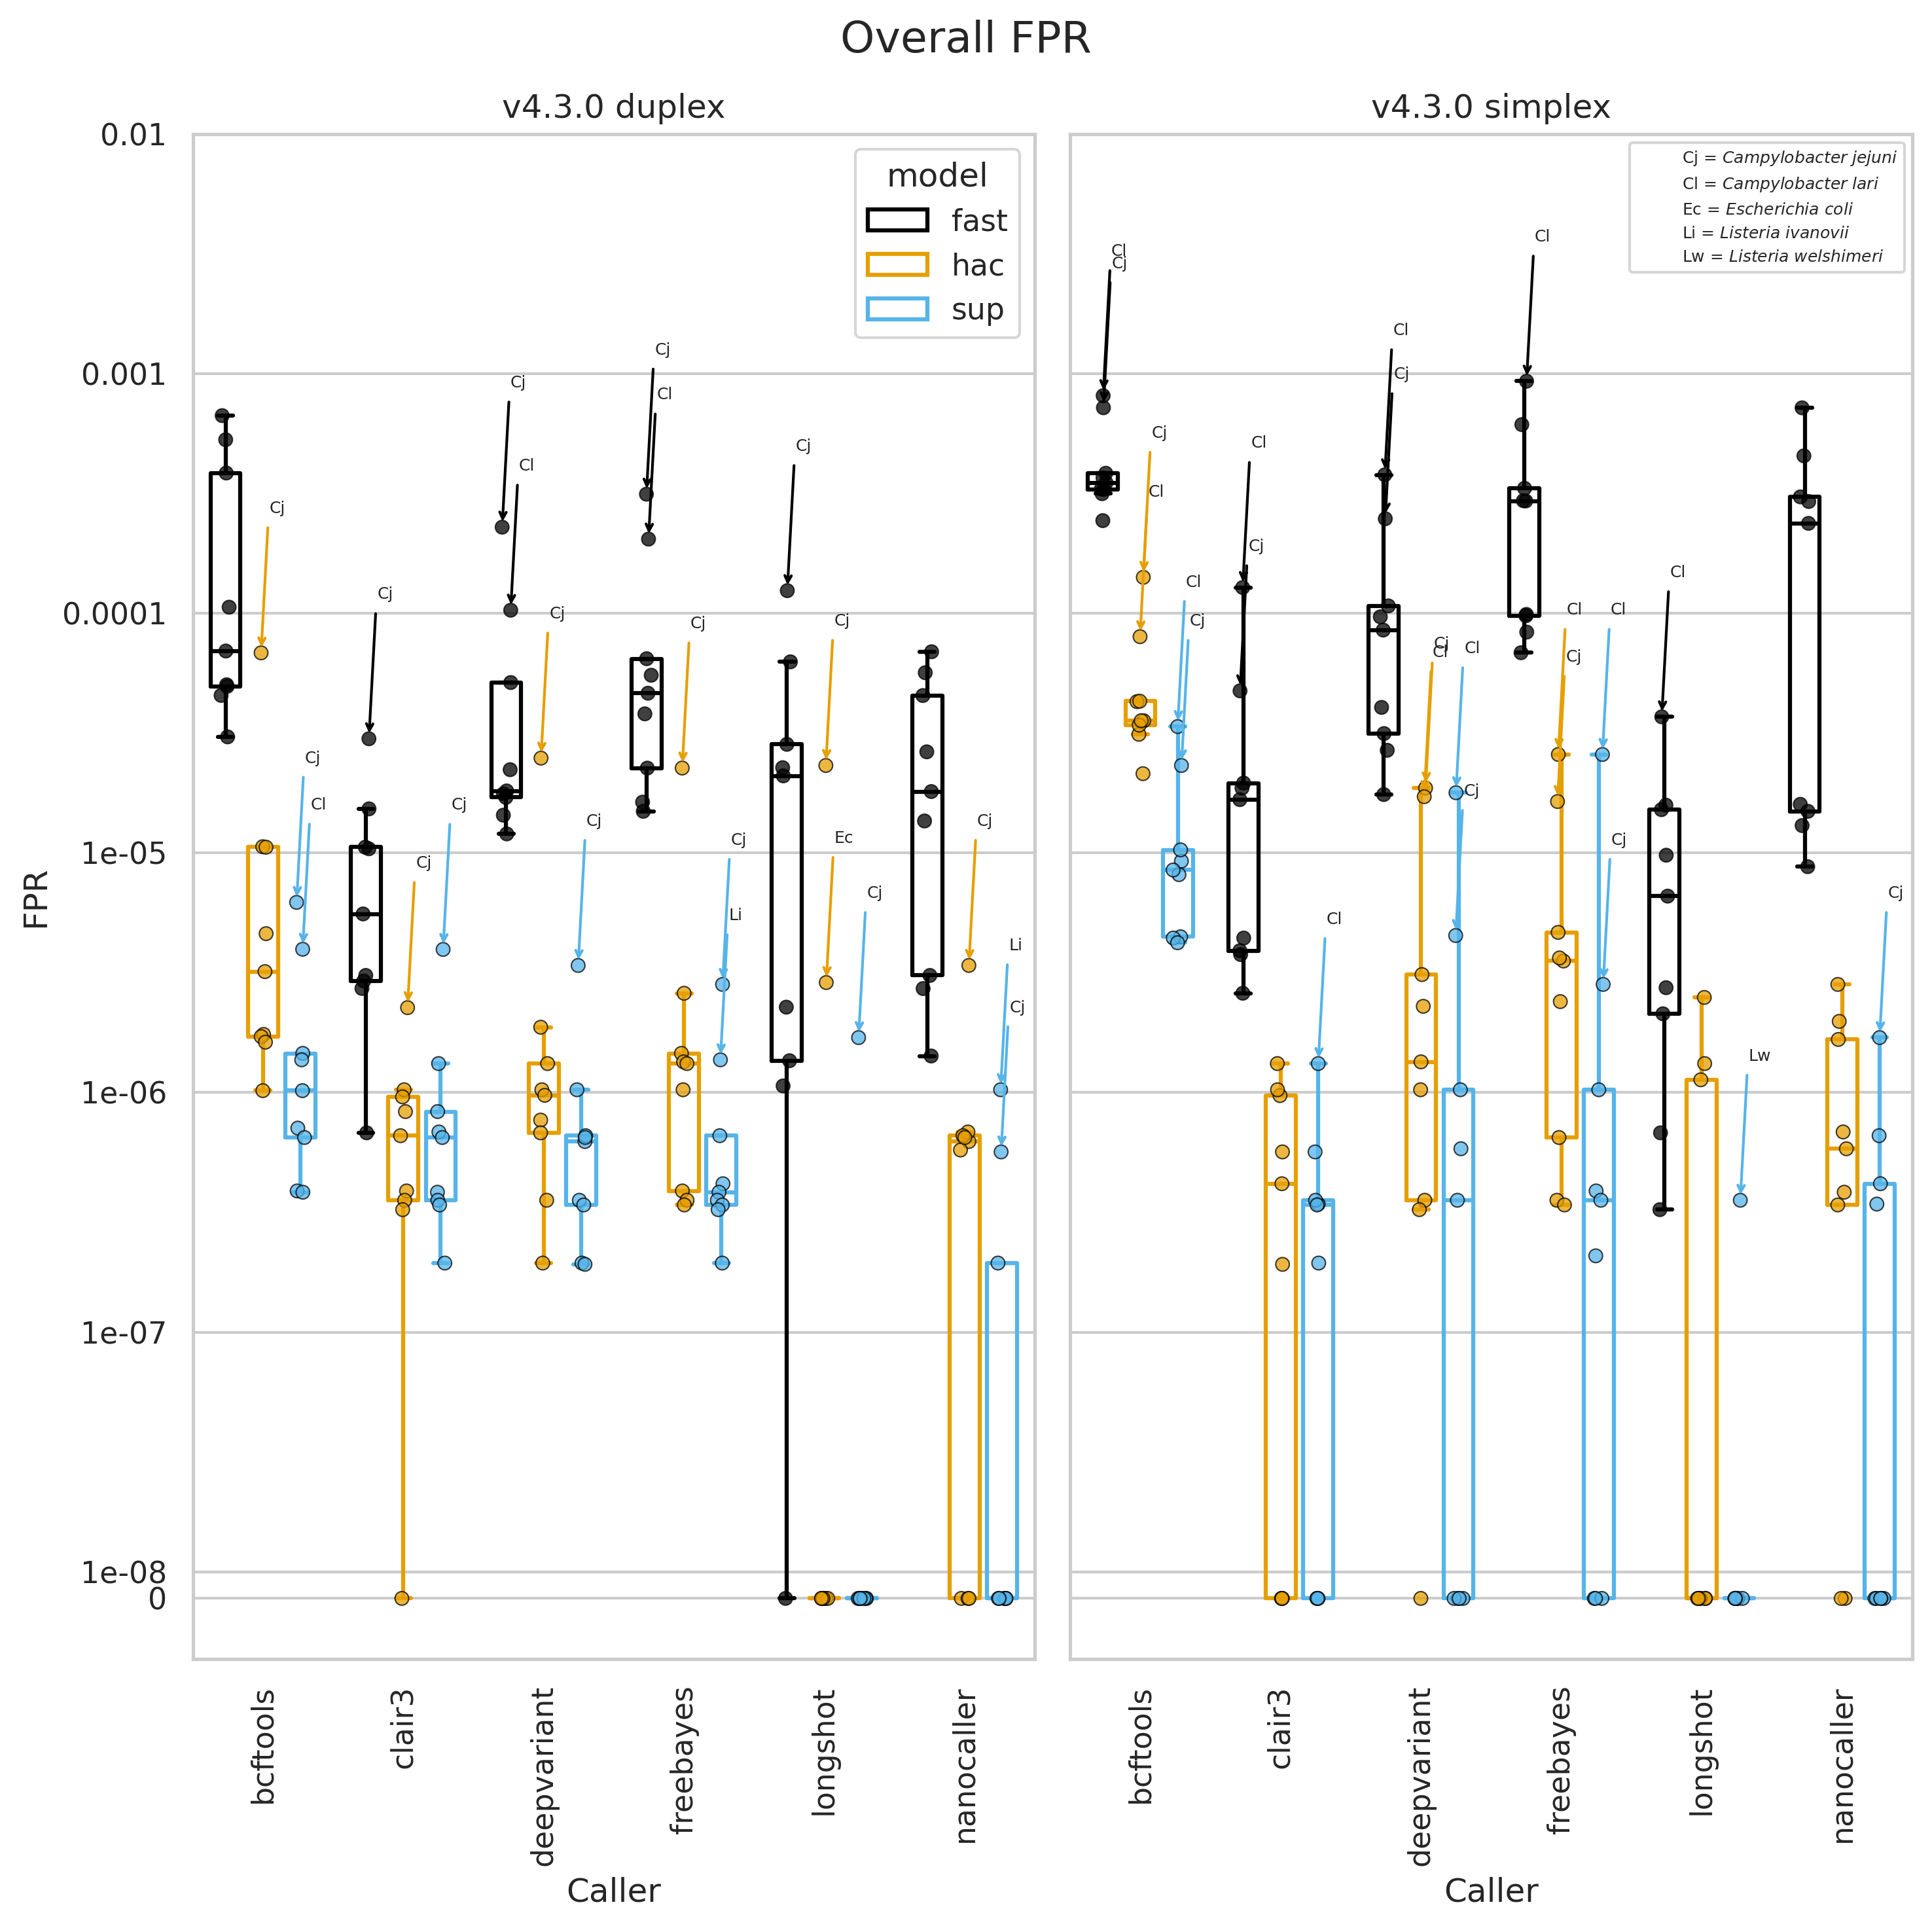

In [194]:
overall_fig, overall_axes = plot_fpr(df, "FPR", "Overall FPR")

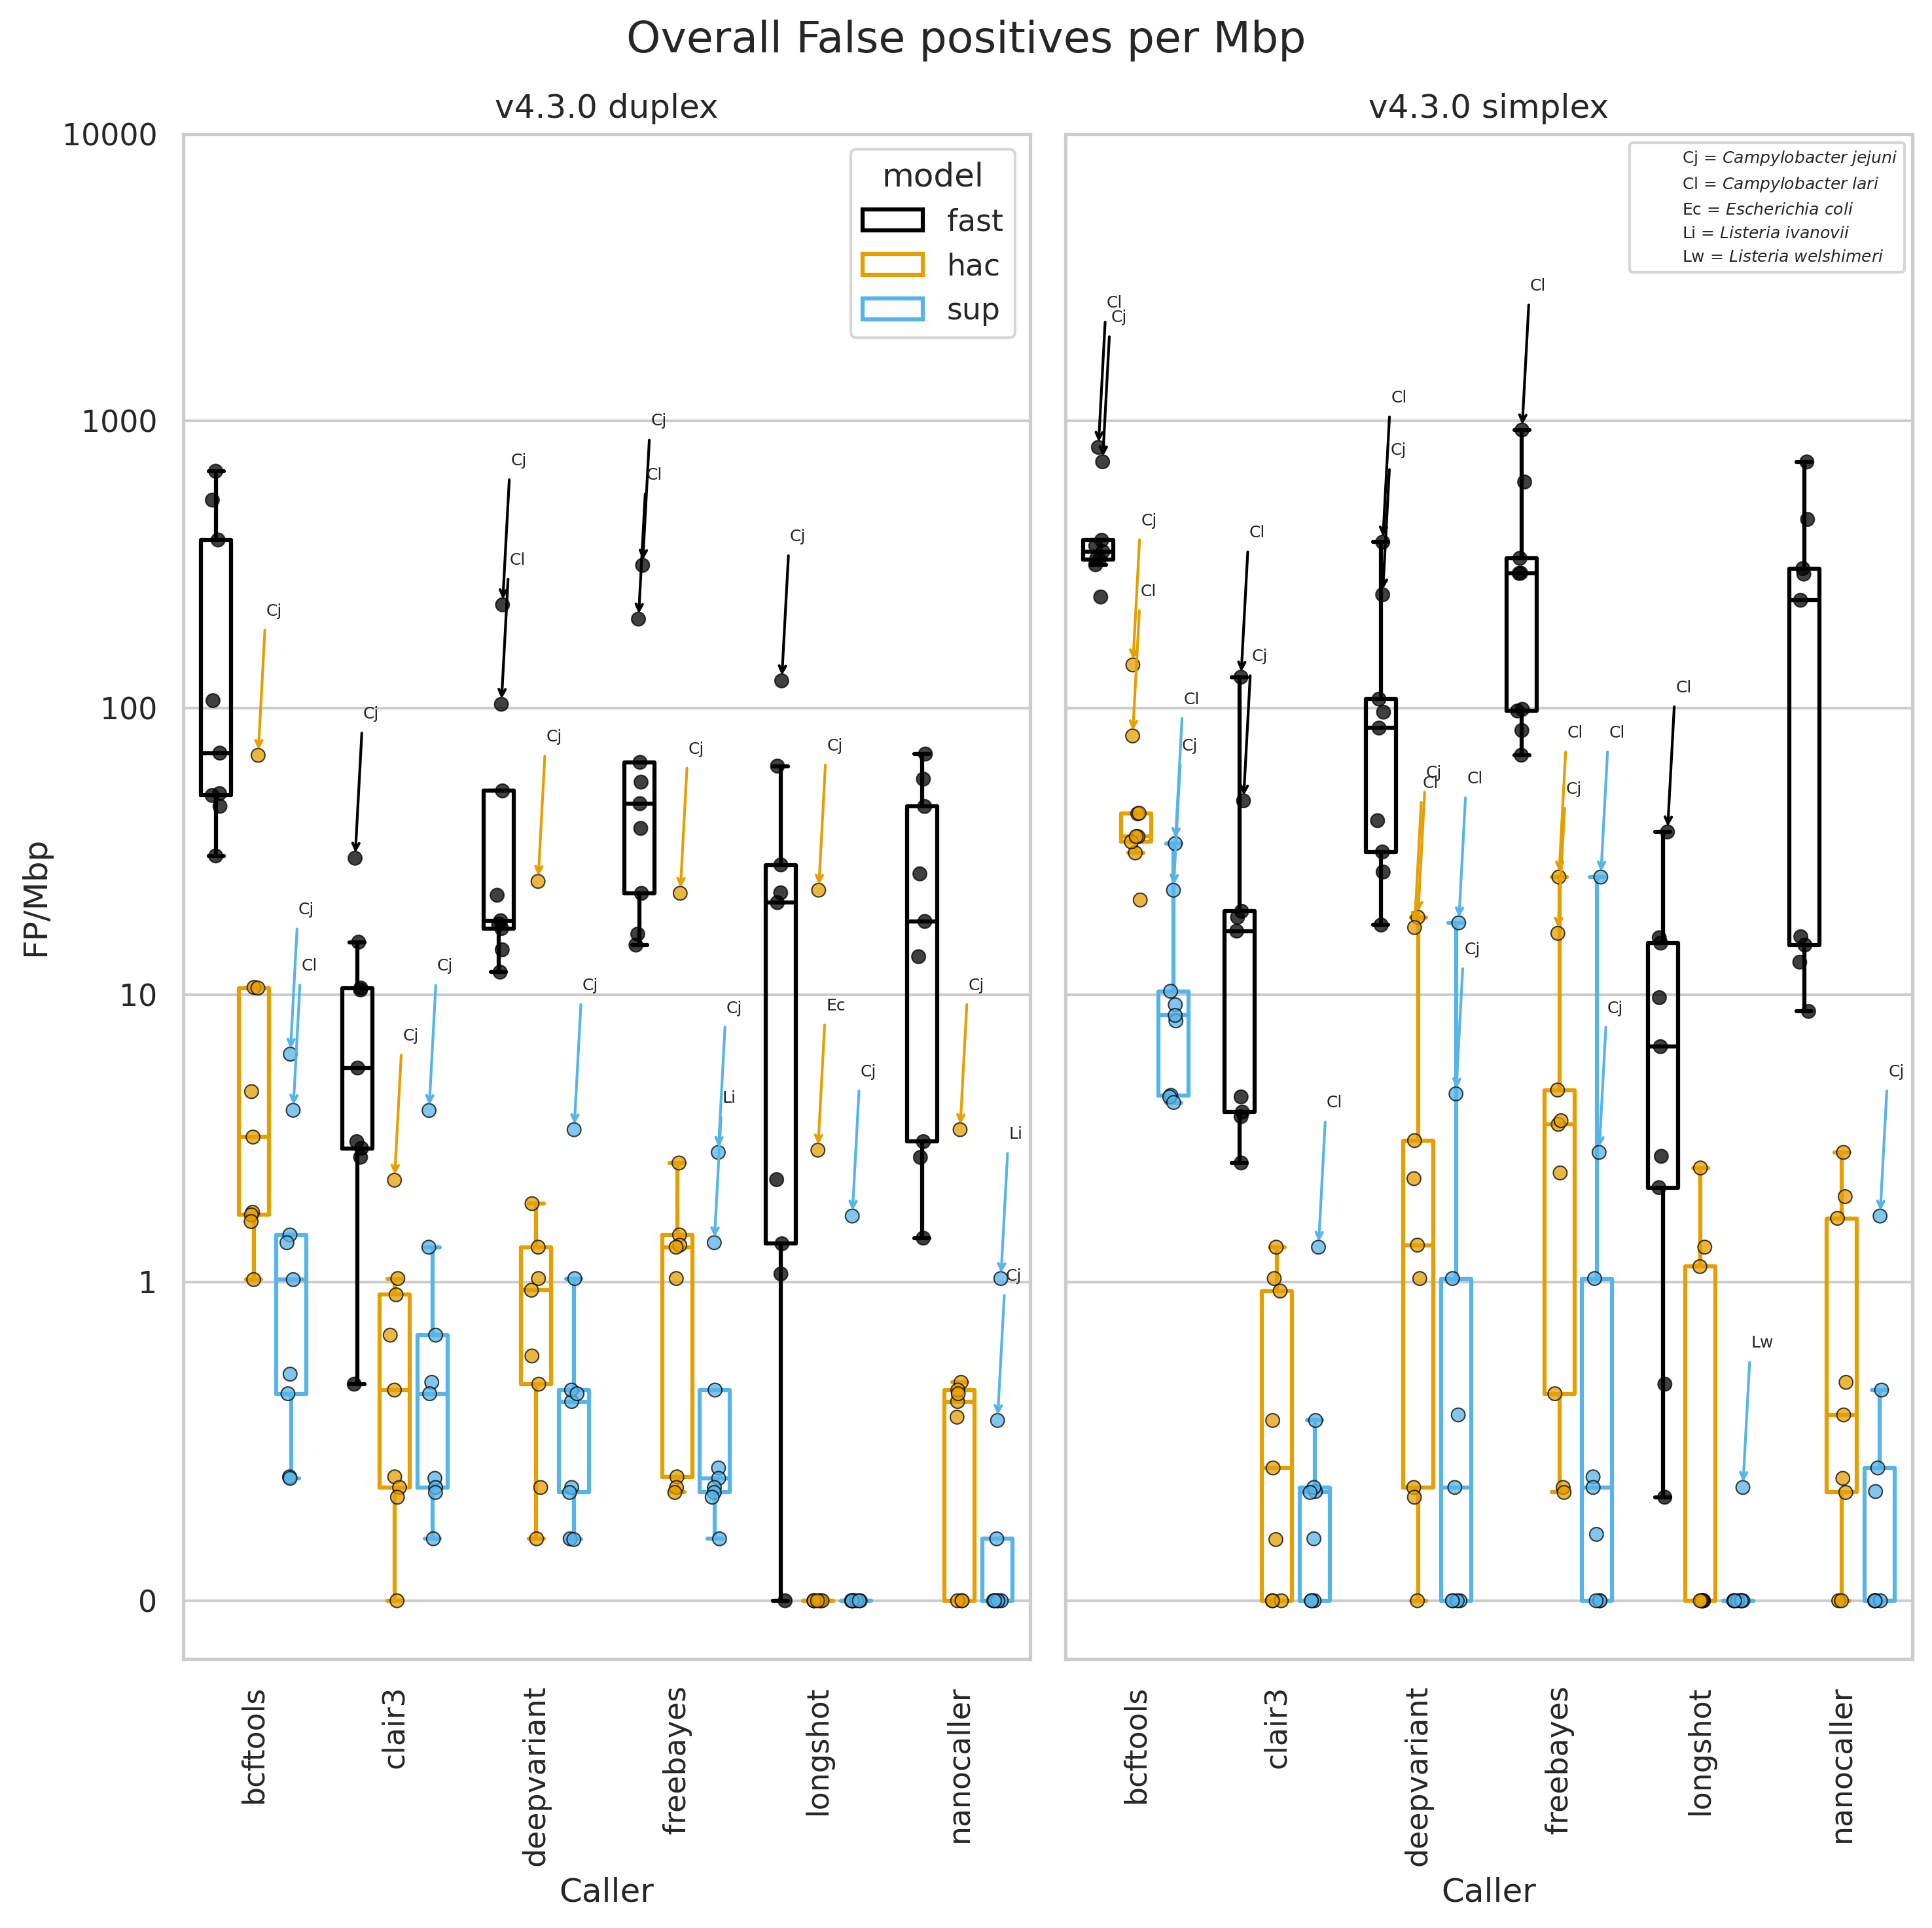

In [195]:
overall_fig, overall_axes = plot_fpr(df, "FP/Mbp", "Overall False positives per Mbp")

## Plotting SNP FPR

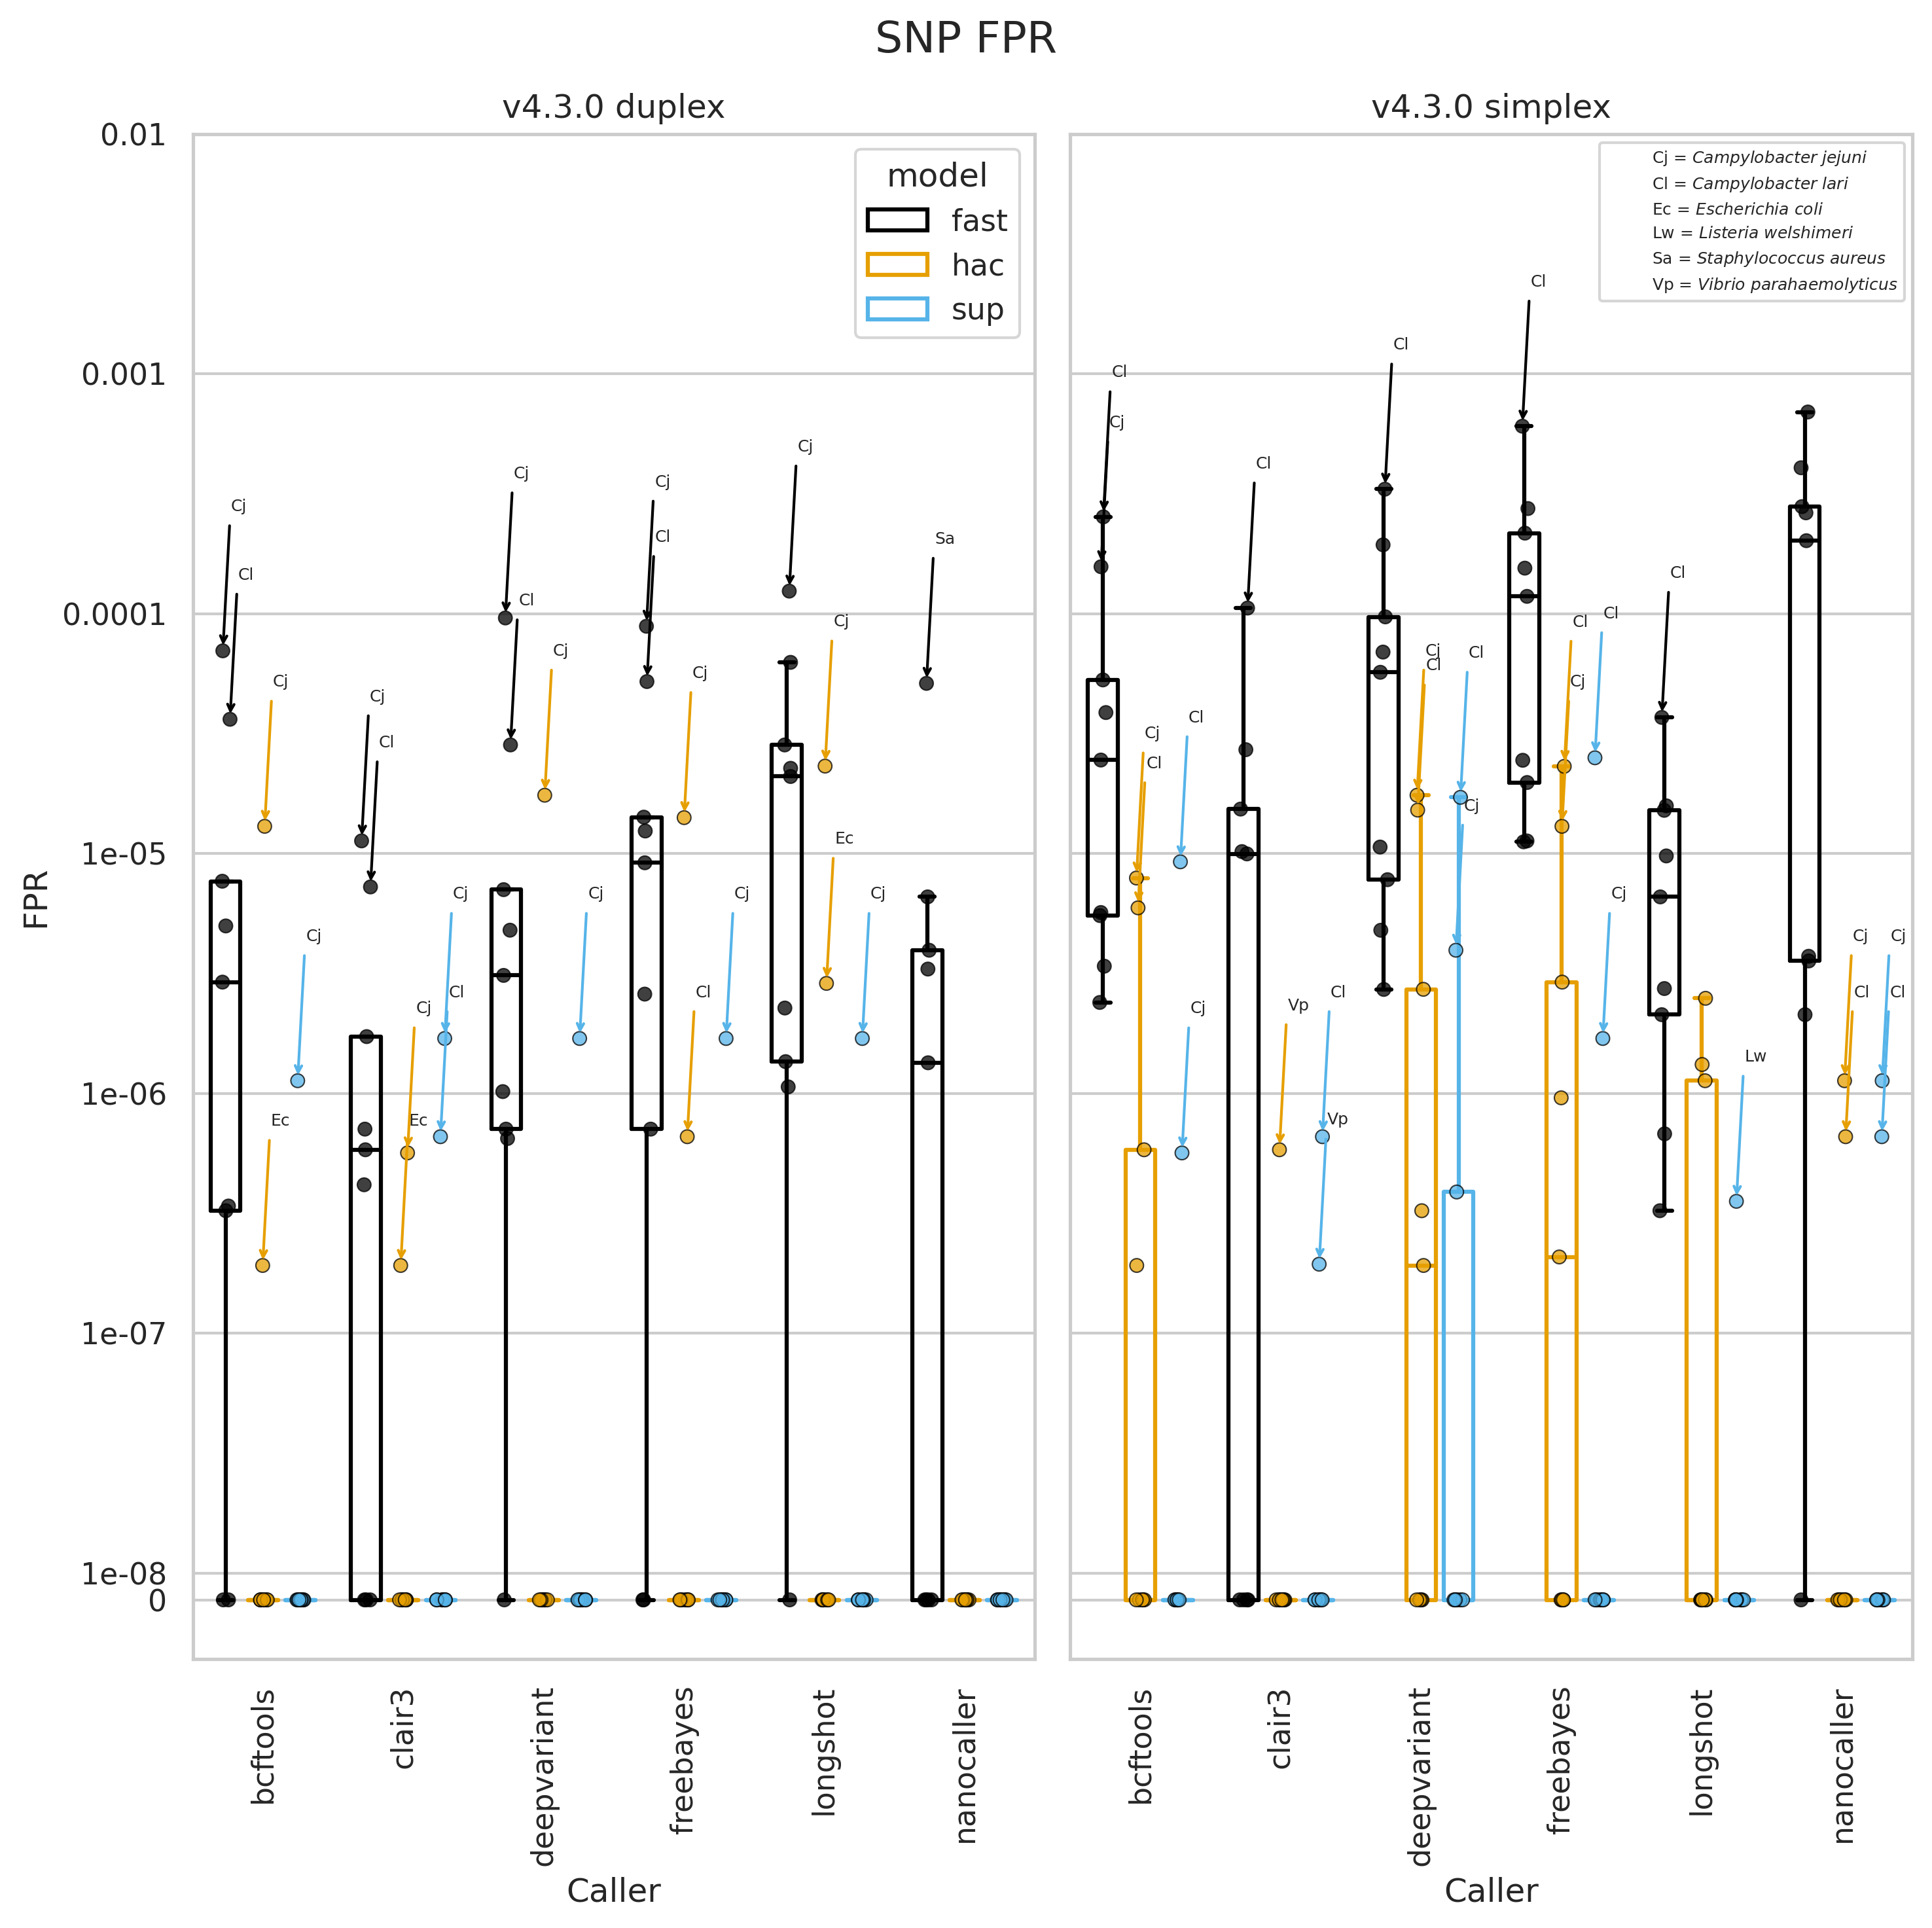

In [196]:
snp_fig, snp_axes = plot_fpr(df, "SNP_FPR", "SNP FPR")

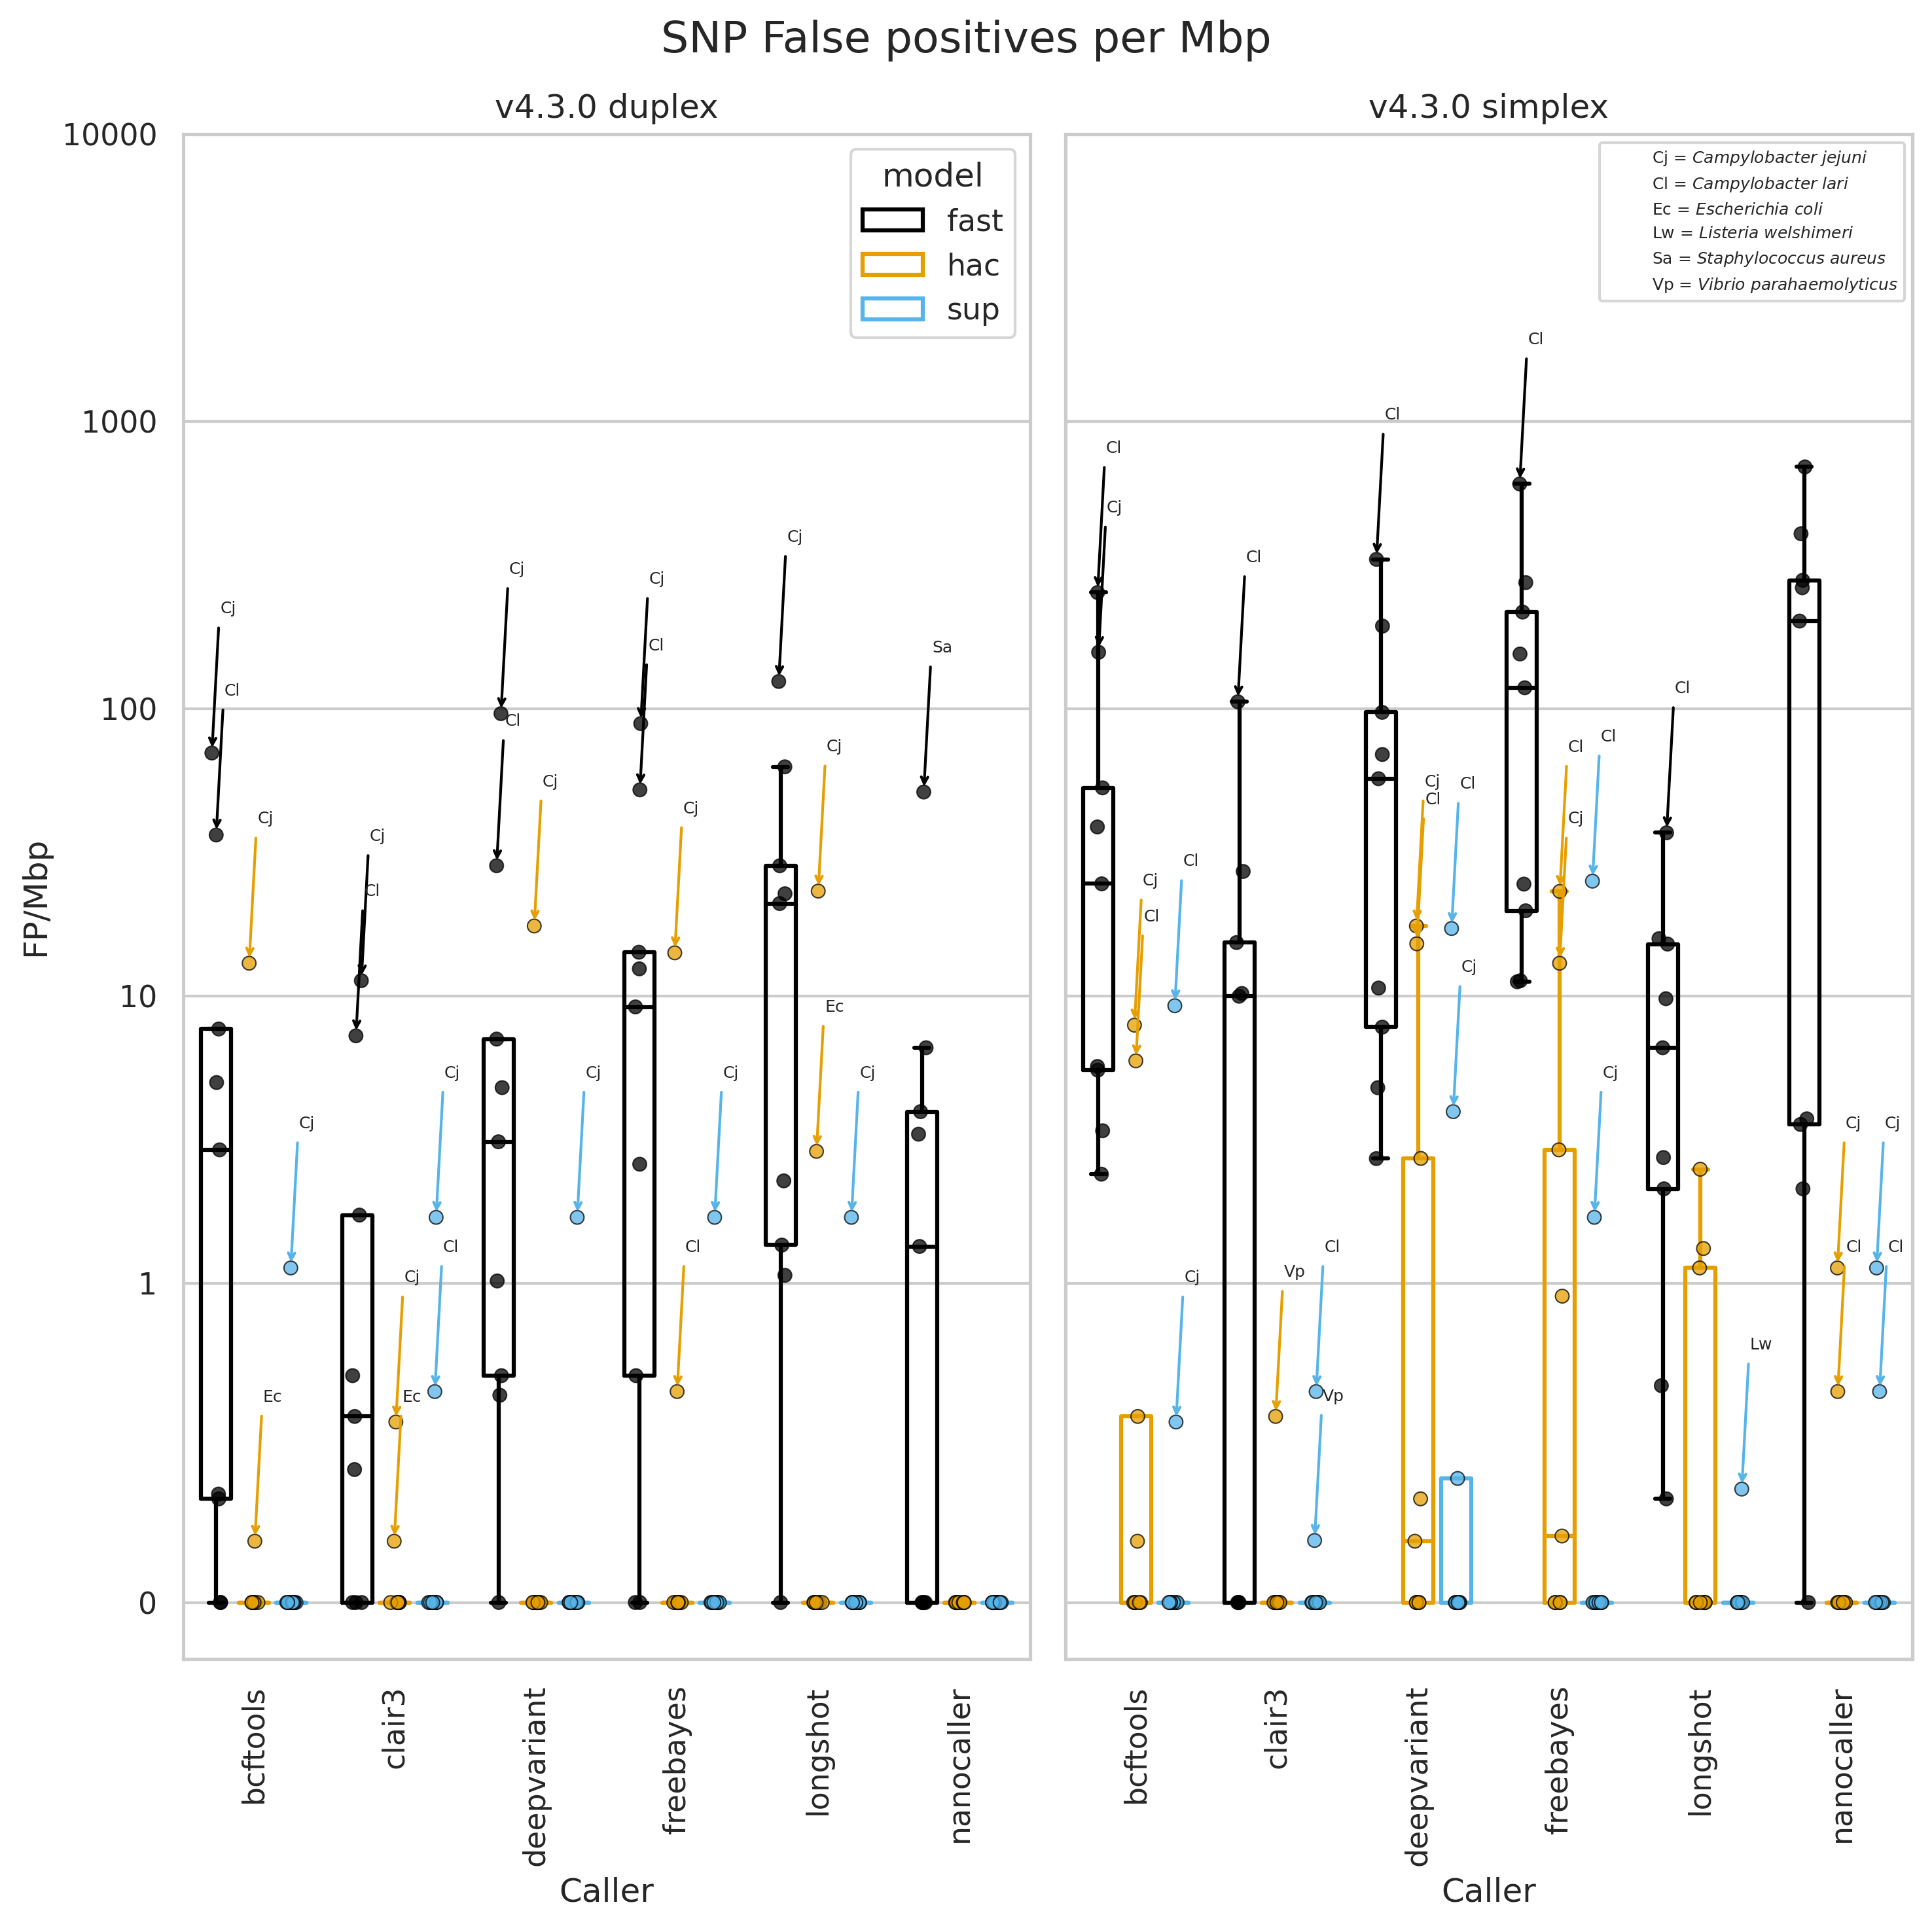

In [197]:
snp_fig, snp_axes = plot_fpr(df, "SNP_FP/Mbp", "SNP False positives per Mbp")

## Plot INDEL FPR

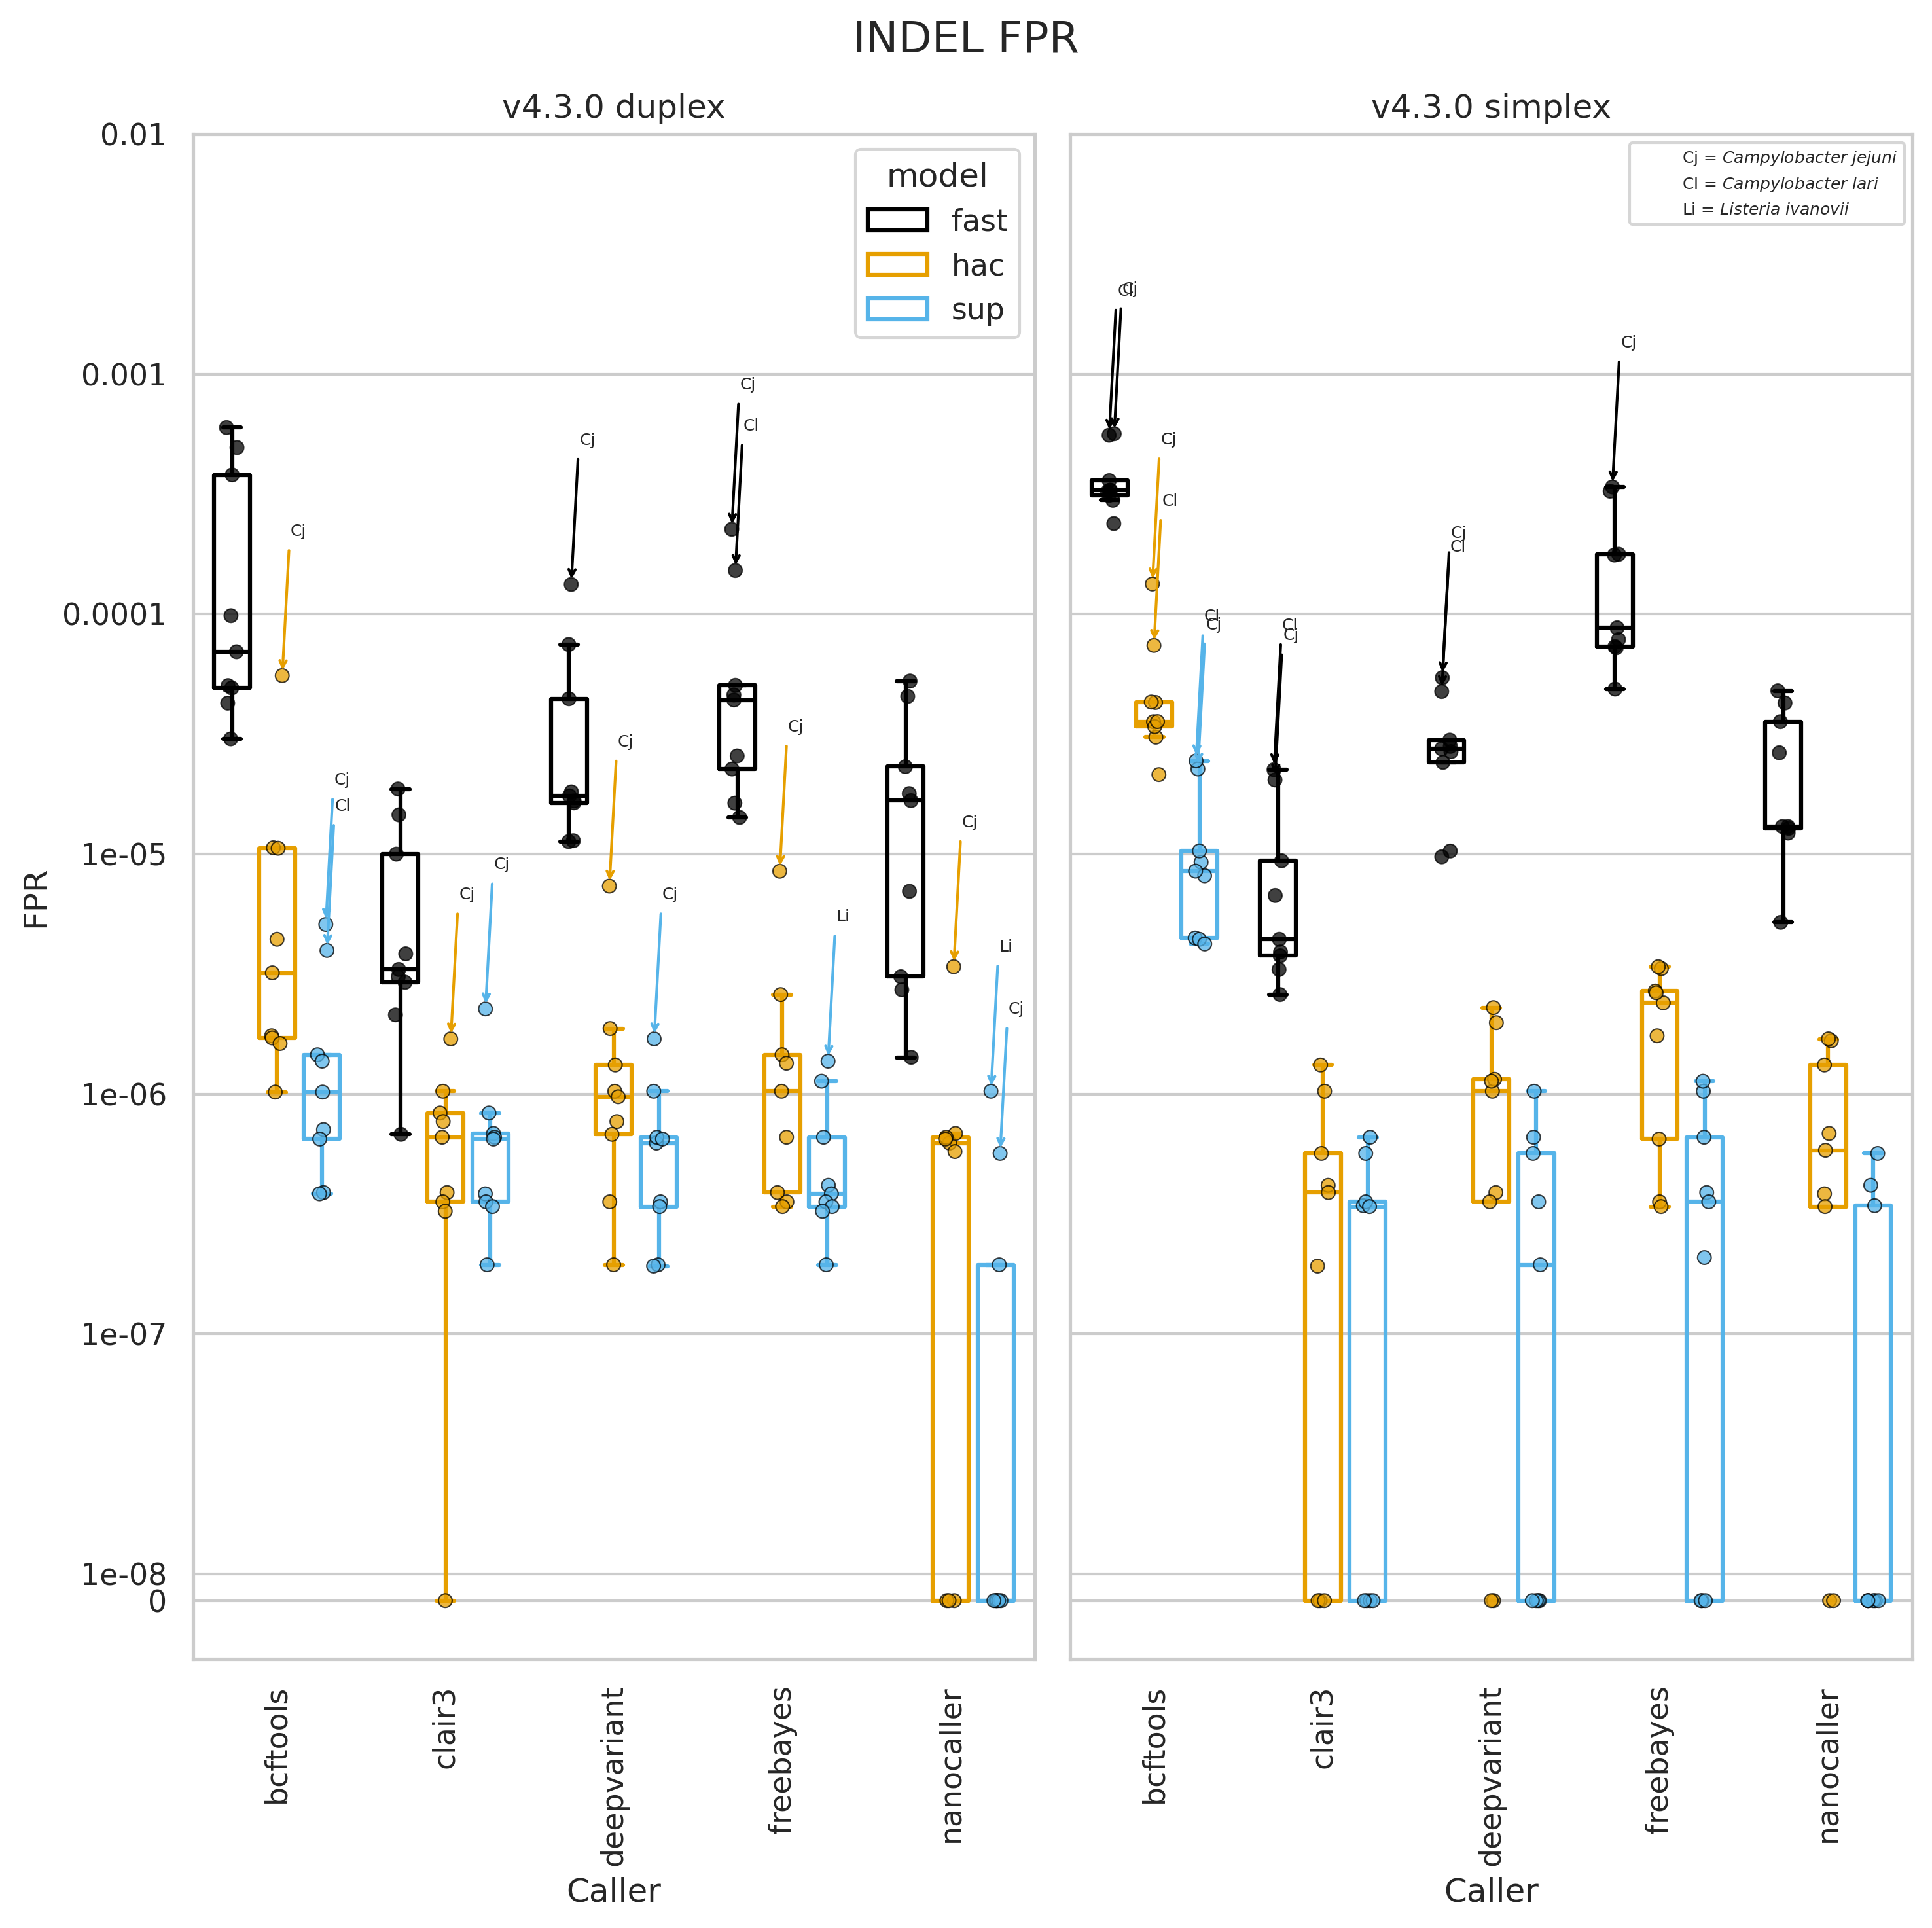

In [198]:
no_indels = ["longshot"]
data = df.query(f"caller not in {no_indels}")
indel_fig, indel_axes = plot_fpr(data, "INDEL_FPR", "INDEL FPR")

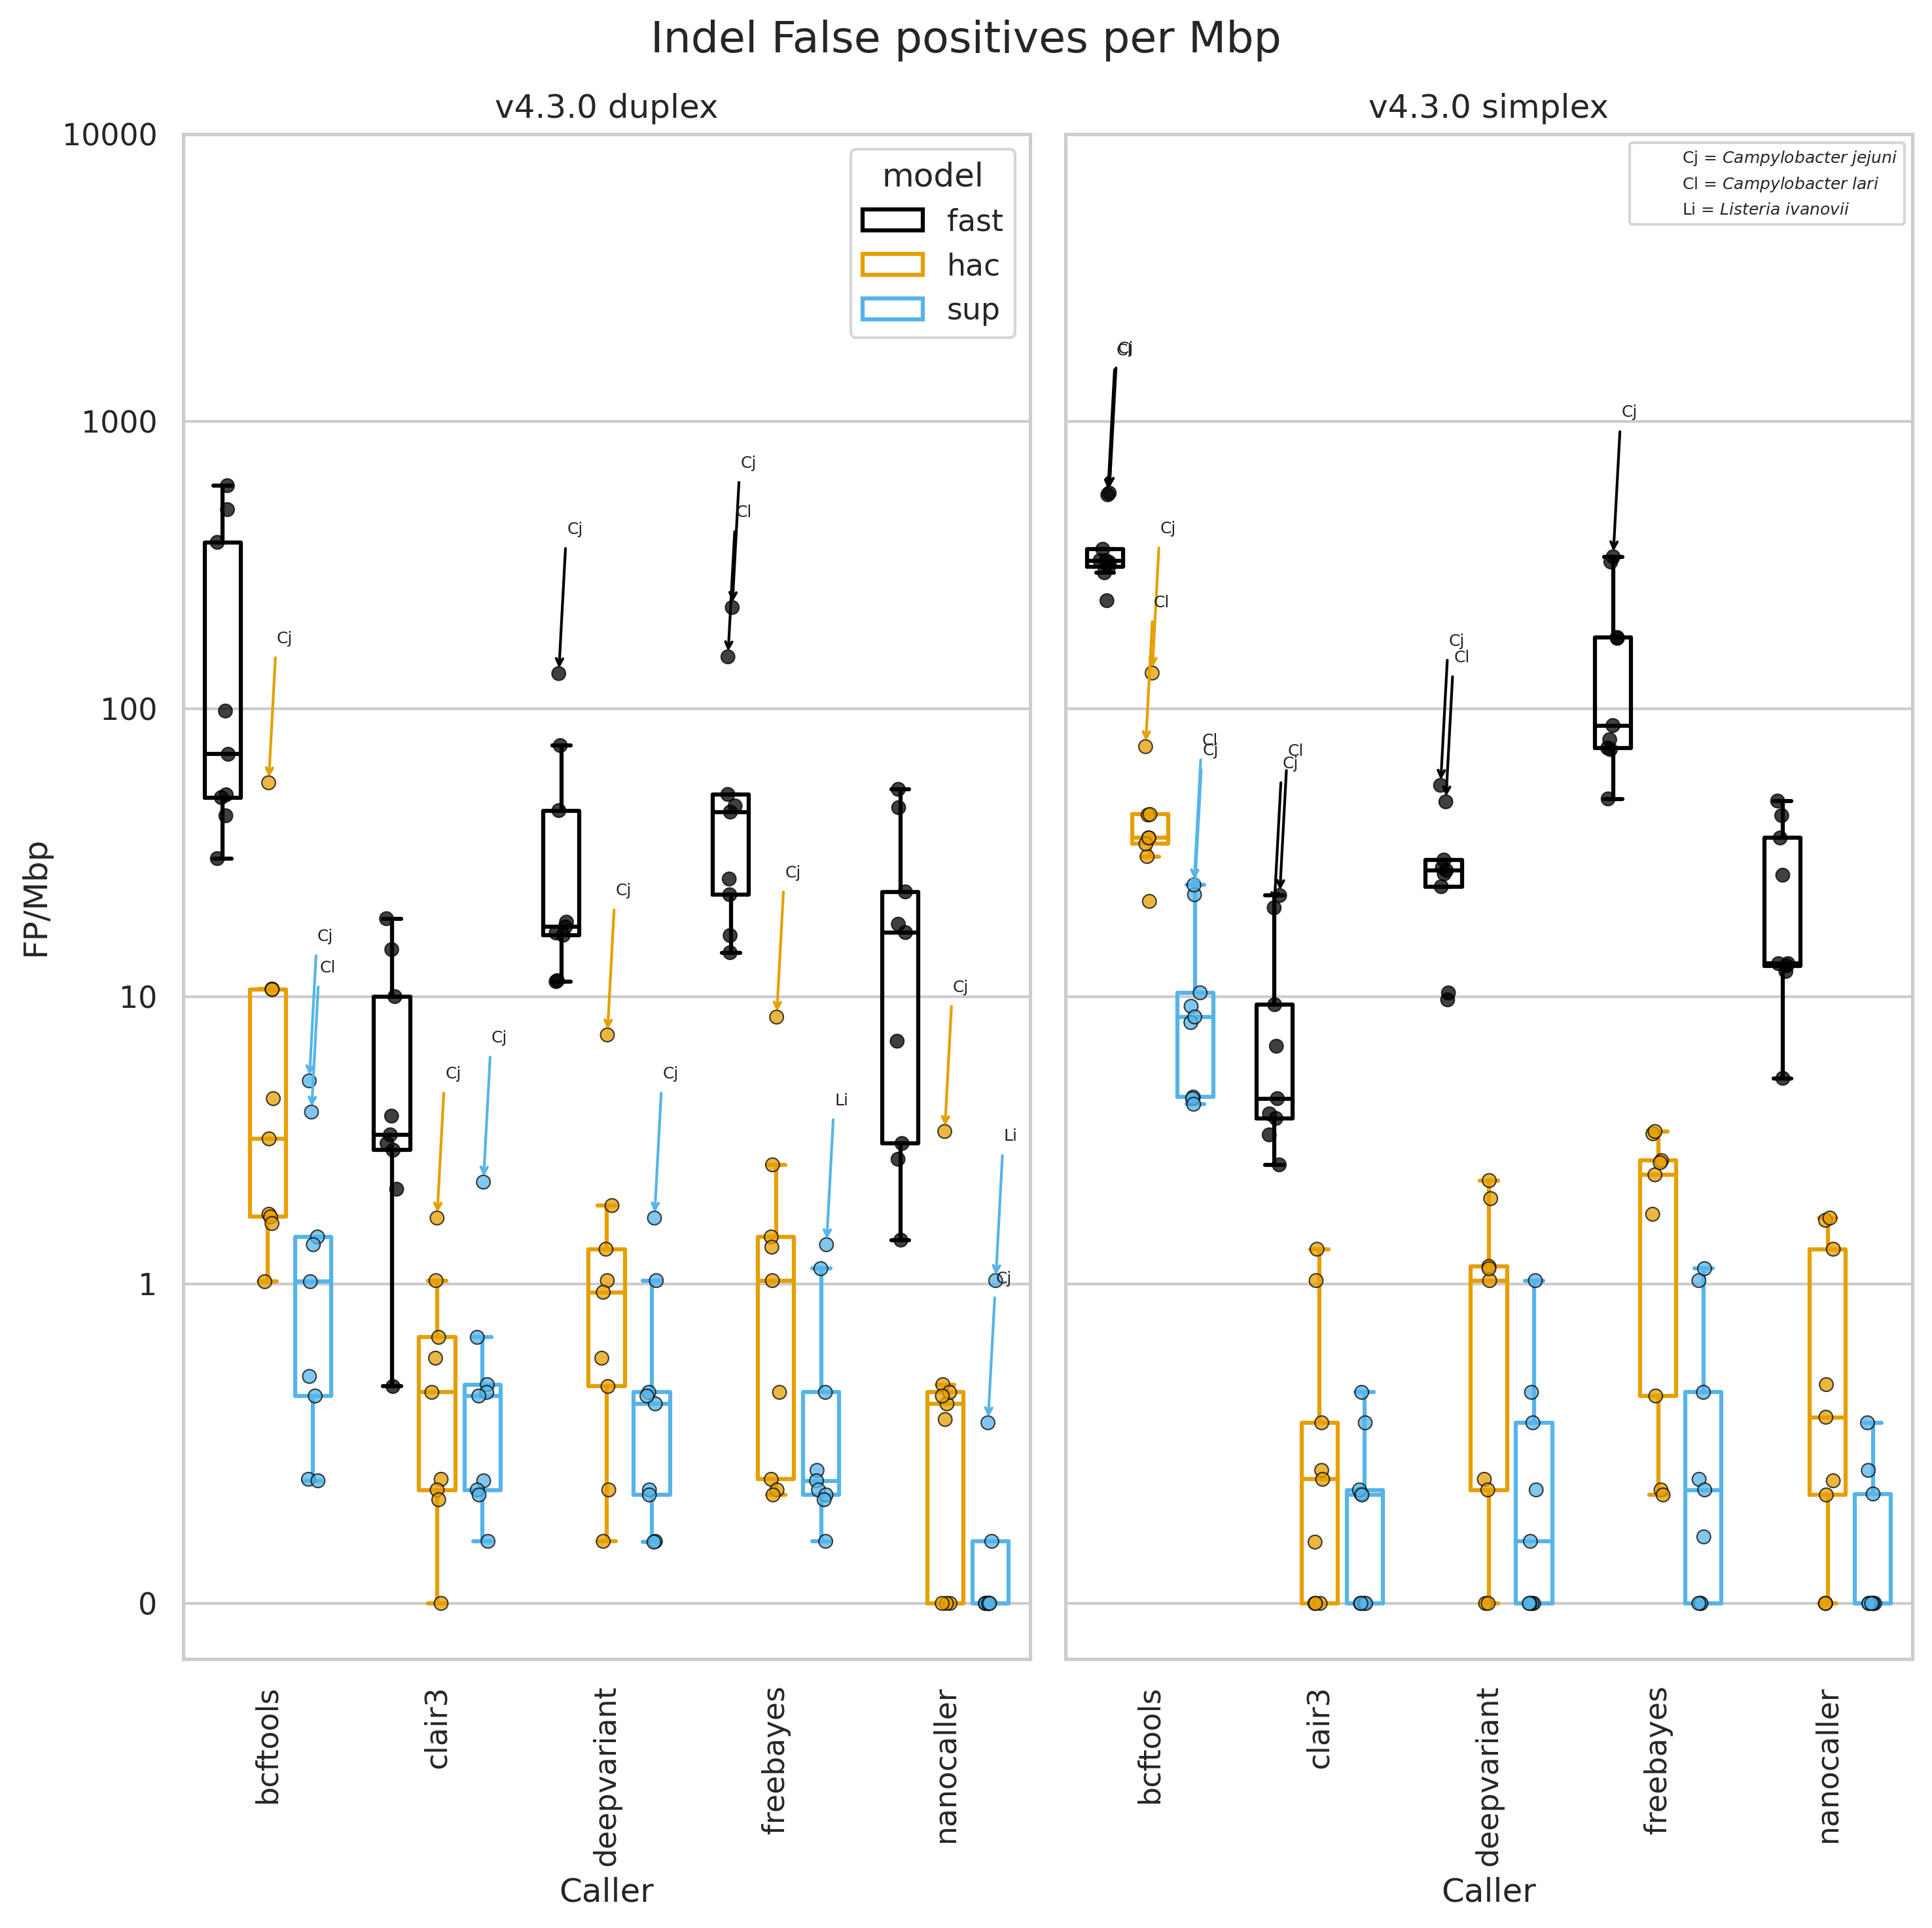

In [199]:
indel_fig, indel_axes = plot_fpr(data, "INDEL_FP/Mbp", "Indel False positives per Mbp")